# The imports

In [1]:
import geopandas as gpd
import geoplot as gplt

import matplotlib.pyplot as plt

import mapclassify as mc

from helper_scripts import utils

# recommended figsize
figsize = (30, 15)


# Loading the data

In [2]:
# Load Nepal district geometry data
map_data = gpd.read_file("../data/nepal_map_data/nepal-districts.geojson")

# Lakes data, we only need the 2nd and 3rd columns
lakes_data = gpd.read_file(
    "../data/OpenDataNepal/NepalCBS/number-of-lakes-in-districts-by-altitude-in-nepal.csv"
).iloc[:, 1:3]


# Preprocess lakes data

In [3]:
# uppercase the district names, cast the count to int
lakes_data["District"] = lakes_data["District"].str.upper()
lakes_data["Total Lake"] = lakes_data["Total Lake"].astype(int)

# join lakes data and geodata on District
final_lakes_data = map_data.merge(
    lakes_data, how="inner", left_on=["DISTRICT"], right_on=["District"]
).iloc[:, 1:]


# Plot the number of lakes data as a choropleth

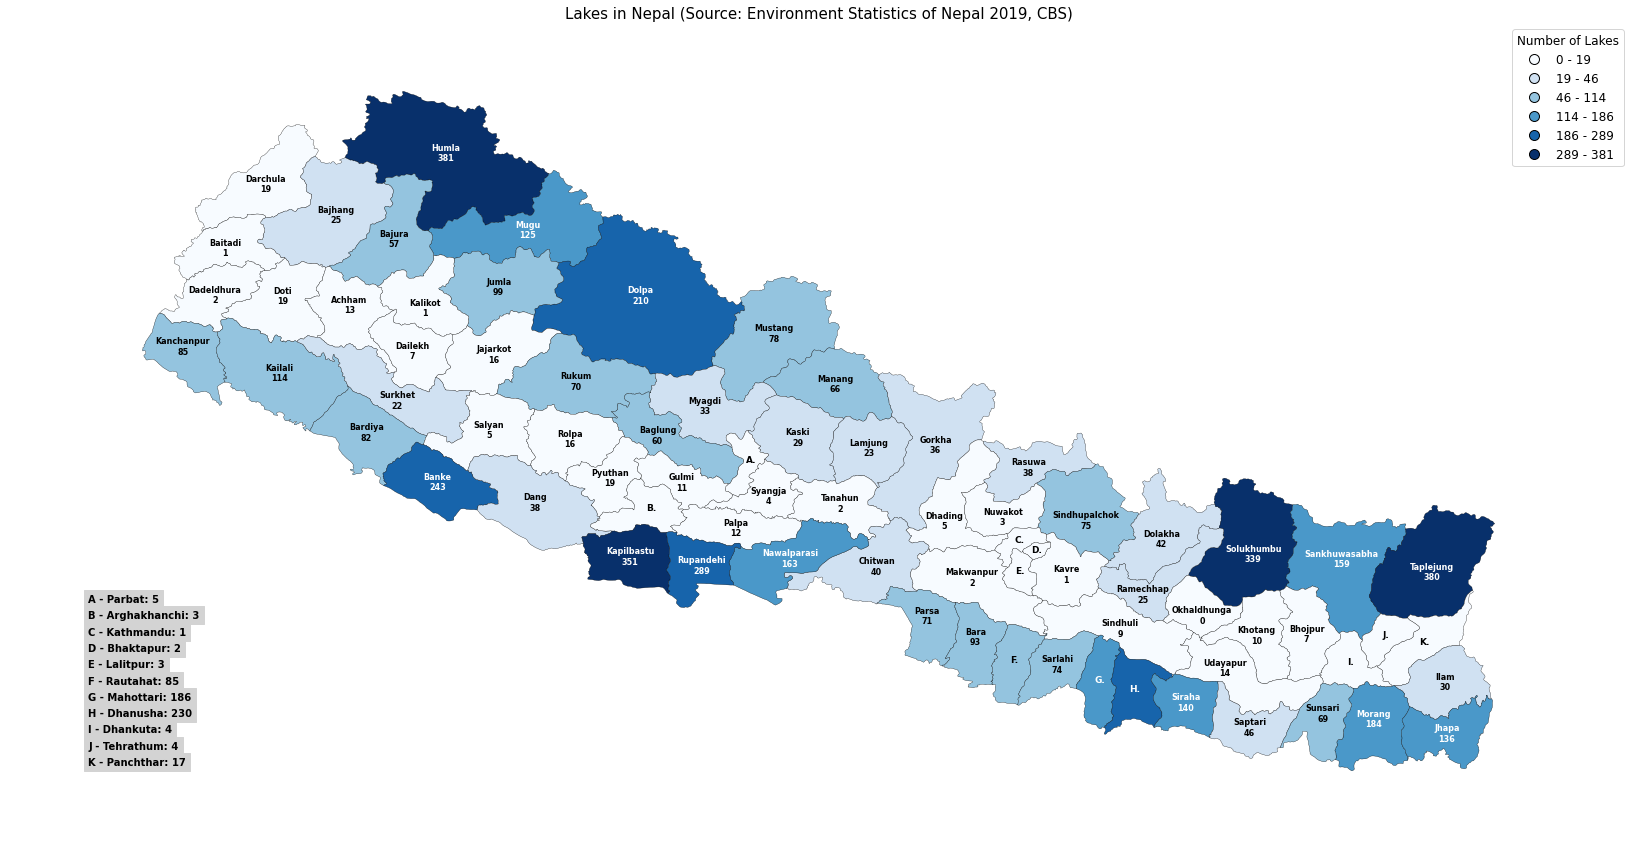

In [4]:
scheme = mc.FisherJenks(final_lakes_data["Total Lake"], k=6)

ax = gplt.choropleth(
    final_lakes_data,
    figsize=figsize,
    hue="Total Lake",
    cmap="Blues",
    linewidth=0.3,
    edgecolor="black",
    legend_kwargs={
        "loc": "best",
        "fontsize": "large",
        "title": "Number of Lakes",
        "title_fontsize": "large",
    },
    legend=True,
    scheme=scheme,
)

# apply labels to every district so they appear on map
final_lakes_data.apply(
    utils.annotate_polygons(
        ax,
        annotation_field="District",
        annotation_value_field="Total Lake",
        threshold=115,
    ),
    axis=1,
)

plt.title(
    "Lakes in Nepal (Source: Environment Statistics of Nepal 2019, CBS)",
    fontdict={"fontsize": 15},
    pad=5,
)

plt.savefig("../visualizations/LakesInNepal.svg", bbox_inches="tight")


# Lakes per unit sq km

#### Areas in sq km conversion

In [5]:
# Changing the projection from unit degree (EPSG:4326) to cartesian (EPSG:6933) and finding area approximation
areas = map_data.copy().to_crs("epsg:6933")["geometry"].area / 10 ** 6

unit_lake_data = final_lakes_data.copy()
unit_lake_data["Total Lake"] = round(unit_lake_data["Total Lake"] / areas, 3)


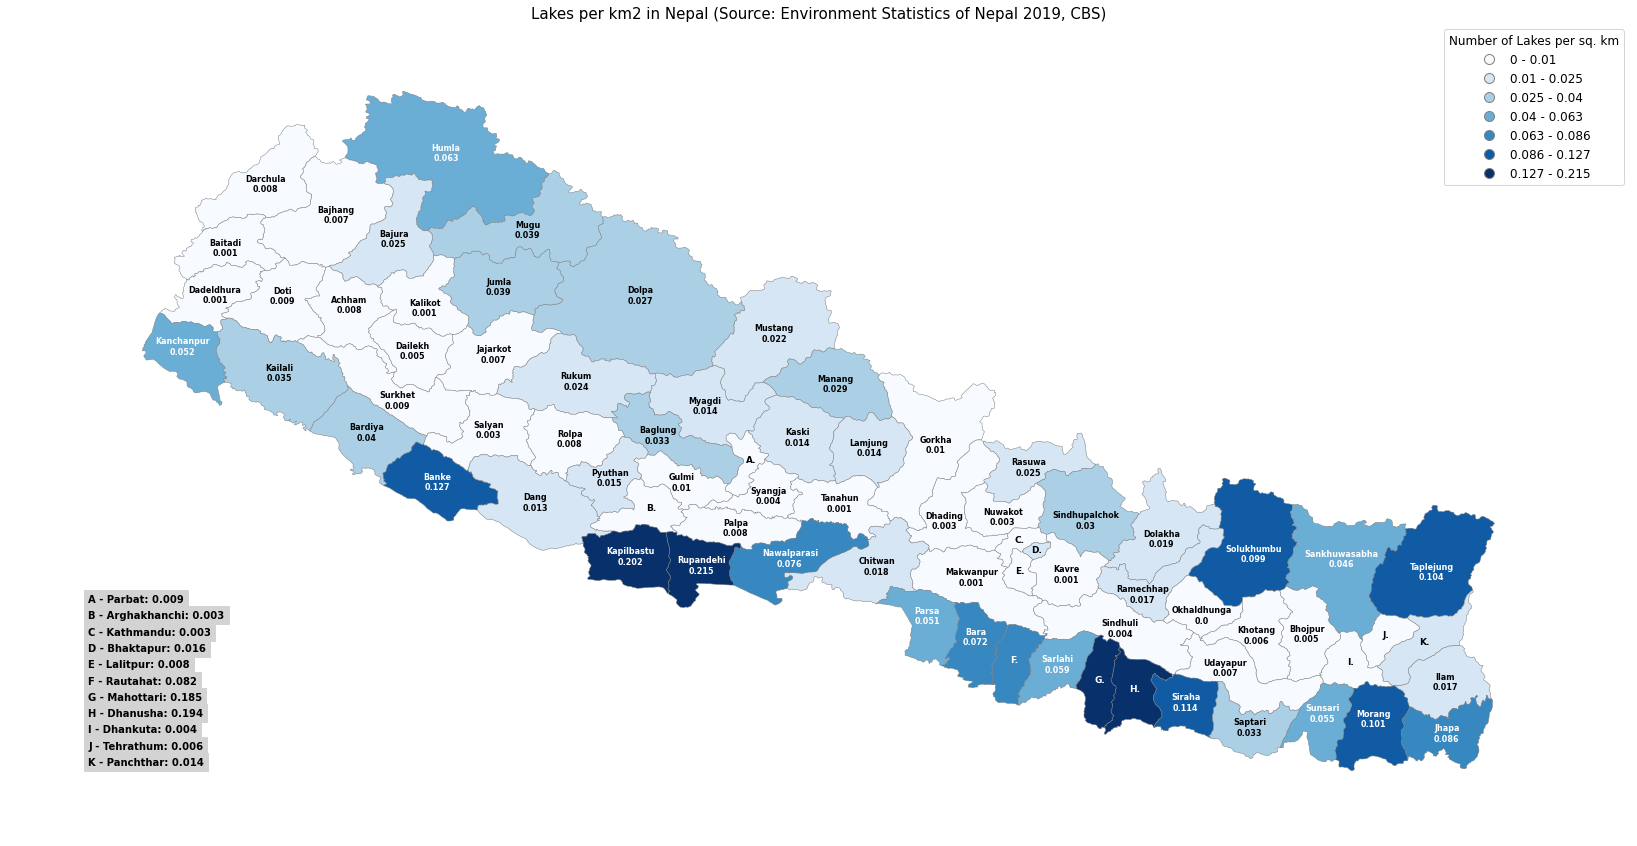

In [6]:
scheme = mc.FisherJenks(unit_lake_data["Total Lake"], k=7)
ax = gplt.choropleth(
    unit_lake_data,
    figsize=figsize,
    hue="Total Lake",
    cmap="Blues",
    linewidth=0.5,
    edgecolor="gray",
    legend_kwargs={
        "loc": "best",
        "fontsize": "large",
        "title": "Number of Lakes per sq. km",
        "title_fontsize": "large",
    },
    legend=True,
    scheme=scheme,
)

unit_lake_data.apply(
    utils.annotate_polygons(
        ax,
        annotation_field="District",
        annotation_value_field="Total Lake",
        threshold=0.04,
    ),
    axis=1,
)

plt.title(
    "Lakes per km2 in Nepal (Source: Environment Statistics of Nepal 2019, CBS)",
    fontdict={"fontsize": 15},
    pad=5,
)
plt.savefig("../visualizations/LakesPuAreaNepal.svg", bbox_inches="tight")
